# Local Wikidata ReAct Agent 0
A conversational agent using a locally hosted LLM and a purpose-built LangChain ReAct agent that can query Wikidata for up-to-date facts and incorporate them into generated responses.

- accesses data via the Wikidata SPARQL endpoint to support inference 
- supports return of implicit facts in the dataset not explicitly on individual records
- defines a narrow scope of functionality in order to deal with the wide ranging schema of Wikidata content

This exercise builds on the `local-wikidata-rag-agent.ipynb` exercise and adds in a purpose-build agent architecture. The goals of hosting locally are to be able to:

- iterate queries and prompts without consuming external resources
- test different language models in order to find the smallest, most efficient model that reliably gets the job done
- move from the "prebuilt" ReAct agent to a customizable agent to which I can iteratively add tools and overcome the limitations of the prebuilt local model by breaking steps down into smaller increments

This particular example creates an agent designed to answer questions about the age and country of origin of medalists in the 2024 Summer Olympics. Sample questions with correct answers (according to Wikidata) are provided below. Verify additional questions (including those that reflect updated data) with [this SPARQL query](https://query.wikidata.org/#%23title%3A%2010%20youngest%20medalists%20of%20the%202024%20Summer%20Olympic%20Games%0A%23description%3A%20Return%20their%20country%2C%20sport%2C%20event%2C%20age%20at%20the%20time%20of%20the%20games%2C%20and%20medal%0APREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0APREFIX%20p%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX%20ps%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fstatement%2F%3E%0APREFIX%20pq%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fqualifier%2F%3E%0A%0A%0ASELECT%20DISTINCT%20%3FsportLabel%20%3FeventLabel%20%3FparticipantLabel%20%3Fage%20%3FcountryLabel%20%3FawardLabel%0A%0AWHERE%20%7B%0A%20%20%3Fsport%20wdt%3AP31%20wd%3AQ26132862%3B%20%20%23%20item%20that%20is%20an%20instance%20of%20olympic%20sports%20discipline%0A%20%20%20%20wdt%3AP361%2B%20wd%3AQ995653%3B%20%20%20%20%20%20%20%23%20and%20part%20of%202024%20games%2C%20or%20part%20of%20an%20event%20that%20was%0A%20%20%20%20wdt%3AP527%20%3Fevent.%20%20%20%20%20%20%20%20%20%20%20%20%23%20and%20hasParts%20that%20are%20individual%20events%0A%20%20%20%20%23%20not%20all%20disciplines%20have%20events%20listed%3B%20this%20list%20will%20be%20missing%20some%20categories%0A%20%20%0A%20%20%23%20get%20full%20statements%20about%20the%20participatns%2C%20participating%20teams%2C%20and%20winners%20of%20those%20events%0A%20%20%3Fevent%20p%3AP710%20%7C%20p%3AP1923%20%7C%20p%3AP1346%20%3FparticipantStatement.%0A%0A%20%20%3FparticipantStatement%20ps%3AP1346%20%7C%20ps%3AP710%20%7C%20ps%3AP1923%20%3Fparticipant%3B%20%20%23%20get%20the%20participant%0A%20%20%20%20%20%20pq%3AP166%20%7C%20pq%3AP2868%20%3Faward.%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23%20and%20that%20participant%27s%20award%0A%0A%20%20%3Fparticipant%20wdt%3AP1532%20%3Fcountry%3B%20%20%20%23%20Get%20the%20country%20the%20participant%20competed%20for%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP569%20%3Fdob.%20%20%20%20%20%20%20%20%23%20and%20their%20date%20of%20birth%0A%0A%20%20%23%20Bind%20closing%20ceremony%20date%20as%20%3Fclosing%0A%20%20BIND%28%222024-08-11%22%5E%5Exsd%3Adate%20AS%20%3Fclosing%29%0A%0A%20%20%23%20Calculate%20approximate%20age%20by%20subtracting%20the%20closing%20date%20from%20the%20participant%27s%20date%20of%20birth%0A%20%20BIND%28%0A%20%20%20%20FLOOR%28%0A%20%20%20%20%20%20%28YEAR%28%3Fclosing%29%20-%20YEAR%28%3Fdob%29%29%20-%0A%20%20%20%20%20%20%20%20IF%20%28MONTH%28%3Fclosing%29%20%3C%20MONTH%28%3Fdob%29%20%7C%7C%20%28MONTH%28%3Fclosing%29%20%3D%20MONTH%28%3Fdob%29%20%26%26%20DAY%28%3Fclosing%29%20%3C%20DAY%28%3Fdob%29%29%2C%201%2C%200%29%0A%20%20%20%20%29%20AS%20%3Fage%29%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%20%20%23%20Use%20SERVICE%20wikibase%3Alabel%20to%20fetch%20labels%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22.%20%7D%0A%7D%0AORDER%20BY%20%3Fage%0A%23%20LIMIT%2010%0A). 

In [1]:
# Instructions for downloading Ollama are at https://github.com/ollama/ollama

%pip install langchain
%pip install langchain_core
%pip install langgraph
%pip install sparqlwrapper
%pip install -qU langchain_ollama

In [2]:
import os

# Enable tracing with LangSmith
# LANGCHAIN_API_KEY environment variable is set in .env
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "agent-0"

# Set the USER_AGENT environment variable
os.environ['USER_AGENT'] = 'langgraph-agent'

## Define graph state

In [3]:
# Define graph state
from typing import (Annotated, Sequence, TypedDict)
from langchain_core.messages import BaseMessage # Base abstract message class
from langgraph.graph.message import add_messages # Reducer. Merges two lists of messages, updating existing messages by ID.

    # A TypedDict type represents dictionary objects with a specific set of string keys, 
    # and with specific value types for each valid key. Each string key can be either 
    # required (it must be present) or non-required (it doesn’t need to exist).
    # https://typing.readthedocs.io/en/latest/spec/typeddict.html#typeddict

class AgentState(TypedDict):
    """The state of the agent."""

    # The Annotated type provides additional metadata that LangGraph uses for special handling of message lists (Tuples). 
    # Annotations specify how updated data should be incorporated into the existing state.
    # The `add_messages` annotation instructs LangGraph to append new steps (a dictionary with a new value) to the existing list, rather than overwriting the entire list with each update.
    
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # the dict returned can have multiple keys:
    # e.g `return {"results": _results, "step_no": step_no+j, }`
    # add any additional keys in this definition

## Define the model and tools

In [4]:
from langchain_ollama import ChatOllama
from SPARQLWrapper import SPARQLWrapper, JSON
from langchain.tools import tool

from typing import Literal

model = ChatOllama(model="llama3.1:8b", temperature=0.3)


@tool
def wikidataOlympicMedalistQuery(
    direction: Literal["ASC", "DESC"] = "ASC", limit: int = 10
) -> str:
    """This tool returns data on medal winners of the 2024 Summer Olympic Games from the Wikidata knowledge graph.
        It returns their country, sport, event, age at the time of the games, and what medal they won.
        By default it returns the 10 youngest medalists in ascending order of age.
        You can return a longer list of athletes by increasing the limit.
        You can change search for the oldest medalists first by changing the direction.
    Args:
        direction: The direction to sort the results.
        limit: The number of results to return."""

    endpoint_url = "https://query.wikidata.org/sparql"

    query = f"""#title: 10 youngest medalists of the 2024 Summer Olympic Games
    #description: Return their country, sport, event, age at the time of the games, and medal
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>
    PREFIX p: <http://www.wikidata.org/prop/>
    PREFIX ps: <http://www.wikidata.org/prop/statement/>
    PREFIX pq: <http://www.wikidata.org/prop/qualifier/>


    SELECT DISTINCT ?sportLabel ?eventLabel ?participantLabel ?age ?countryLabel ?awardLabel

    WHERE {{
    ?sport wdt:P31 wd:Q26132862;    # item that is an instance of olympic sports discipline
        wdt:P361+ wd:Q995653;       # and part of 2024 games, or part of an event that was
        wdt:P527 ?event.            # and hasParts that are individual events
                                    # not all disciplines have events listed: this list will be missing some categories

    # get full statements about the participants, participating teams, and winners of those events
    ?event p:P710 | p:P1923 | p:P1346 ?participantStatement.

    ?participantStatement ps:P1346 | ps:P710 | ps:P1923 ?participant;  # get the participant
        pq:P166 | pq:P2868 ?award.                                     # and that participant's award

    ?participant wdt:P1532 ?country;   # Get the country the participant competed for
                wdt:P569 ?dob.         # and their date of birth

    # Bind closing ceremony date as ?closing
    BIND("2024-08-11"^^xsd:date AS ?closing)

    # Calculate approximate age by subtracting the closing date from the participant's date of birth
    BIND(
        FLOOR(
        (YEAR(?closing) - YEAR(?dob)) -
            IF (MONTH(?closing) < MONTH(?dob) || (MONTH(?closing) = MONTH(?dob) && DAY(?closing) < DAY(?dob)), 1, 0)
        ) AS ?age)
                
    # Use SERVICE wikibase:label to fetch labels
    SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    ORDER BY {direction}(?age)
    LIMIT {limit}
    """

    def get_results(endpoint_url, query):
        user_agent = "LlmIntegration/0.0 (https://github.com/andybywire/)"
        sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        return sparql.query().convert()

    results = get_results(endpoint_url, query)

    def create_statements(results):
        statements = []
        if results:
            for result in results["results"]["bindings"]:
                statement = f"{result['participantLabel']['value']}, age {result['age']['value']} from {result['countryLabel']['value']}, won a {result['awardLabel']['value'].replace('Olympic','')} in {result['eventLabel']['value'].replace(' – ',', ')}."
                statements.append(statement)
        return statements

    return create_statements(results)


tools = [wikidataOlympicMedalistQuery]

model = model.bind_tools(tools)

## Define nodes and routing functions

In [5]:
# Define nodes and edges
import json
from langchain_core.messages import (
    ToolMessage,
    SystemMessage,
)  # use to create objects for the messages

tools_by_name = {tool.name: tool for tool in tools}


# Define the tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


prompt = "You are an assistant designed for answering questions about the results of the 2024 Summer Olympics. Use the tool at your disposal to answer the question. If the data provided doesn't answer the question, use the tool again with a larger return limit or a different sort order. If you still can't find the the answer, say that you don't know. Keep your answers concise and limit your responses to 3-4 sentences or brief lists.Do not give up on the first try with the tool. If you don't see the answer, try again using a different limit or sort order."


# Define the node that calls the model
def call_model(
    state: AgentState,
):
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible
    system_prompt = SystemMessage(prompt)
    response = model.invoke([system_prompt] + state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

## Create the graph
Initialize, add nodes, add edges.

In [6]:
from langgraph.graph import StateGraph, END
from langgraph.constants import END

# Define the graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
# Each node will emit an update on the state when leaving the node
# Nodes take the state as input, perform modifications, and return the updated state. 
# See: https://langchain-ai.github.io/langgraph/concepts/low_level/#state
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# Add conditional edges
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping. The keys are strings, and the values are other nodes.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish. ... pass to validate
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, the `agent` node is called next.
workflow.add_edge("tools", "agent")

graph = workflow.compile()

# If needed, use a checkpointer like MemorySaver to persist state between graph runs:
# checkpointer = MemorySaver()
# graph = workflow.compile(checkpointer=checkpointer)

## Visualize the graph

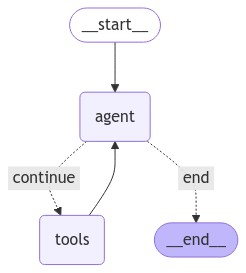

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the agent

In [ ]:
from langchain_core.messages import HumanMessage

# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

questions = [
    "Who were the youngest medalists at the 2024 Summer Olympics and what did they win?",
    "What countries were the youngest medalists at the 2024 Summer Olympics from?",
    "Who was the youngest medalist from Japan in the 2024 Summer Olympic games?",
    "What event in the 2024 Summer Olympics did the youngest medalist from Spain win?",
    "Who was the youngest medalist at the Summer 2024 Olympics from a country in Africa and what event did they win?",
    "Who was the oldest medalist at the 2024 Olympics from a country in Africa?",
    "Who was the youngest fencing medalist at the 2024 Olympic Games?",
]

inputs = {"messages": [("user", questions[1])]}

    # Same as above:
    # inputs = {
    #     "messages": [
    #         HumanMessage(
    #             content=questions[0]
    #             )
    #         ]
    #     }

# Call the graph
print_stream(graph.stream(inputs, stream_mode="values"))

    # Sample questions & correct answers
    #
    # Who were the youngest medalists at the 2024 Summer Olympics and what did they win?
    #   - 1. Ban Hyo-jin (South Korea) - age 16, gold medal in shooting (women's 10 metre air rifle).
    #   - 2. Dominika Banevič (Lithuania) - age 17, silver medal in breaking (B-girls).
    #   - 3. Darja Varfolomeev (Germany) - age 17, gold medal in gymnastics (women's rhythmic individual all-around).
    #   - 4. Quan Hongchan (People's Republic of China) - age 17, gold medal in diving (women's 10 metre platform). 
    # What countries were the youngest medalists at the 2024 Summer Olympics from?
    #   - South Korea, Lithuania, Germany, People's Republic of China, Russia
    # Who was the youngest medalist from Japan in the 2024 Summer Olympic games?
    #   - Ami Yuasa
    # What event in the 2024 Summer Olympics did the youngest medalist from Spain win?
    #   - Men's tennis singles, Carlos Alcaraz, 21
    # Who was the youngest medalist at the Summer 2024 Olympics from a country in Africa and what event did they win?
    #   - Emmanuel Wanyonyi from Kenya, who won a gold medal in athletics (men's 800 metres)
    # Who was the oldest medalist at the 2024 Olympics from a country in Africa?
    #   - Hellen Obiri from Kenya, who won a bronze medal in athletics (women's marathon)
    # Who was the youngest fencing medalist at the 2024 Olympic Games?
    #  - As of 9.13.24, this should return no results: fencing data is not yet available in Wikidata
